In [28]:
# paquetes necesarios
import pandas as pd
import numpy as np
import random
import copy

In [29]:
# lectura de archivos, Paridad.csv
pdf = pd.read_csv("Paridad.csv")
entradas = list(pdf[["A","B","C"]].itertuples(index=False, name=None))
salidas = pdf["S"].tolist()

In [30]:
# definición de los operadores lógicos 
class Booleanos:
    def __init__(self, operador, hijos=None):
        self.operador = operador
        self.hijos = hijos or []

    def eval(self, v):
        # terminal
        if not self.hijos:
            if self.operador in v:
                return v[self.operador]
            if self.operador in ("0", "1"):
                return int(self.operador)
            raise ValueError(f"Terminal desconocido: {self.operador}")
        # no terminal
        valores = [h.eval(v) for h in self.hijos]
        if self.operador == "AND":
            return valores[0] & valores[1]
        if self.operador == "OR":
            return valores[0] | valores[1]
        if self.operador == "NOT":
            return 1 - valores[0]
        if self.operador == "XOR":
            return valores[0] ^ valores[1]
        raise ValueError(f"Operador desconocido: {self.operador}")

    def lectura(self):
        # terminal
        if not self.hijos:
            return self.operador
        # NOT
        if self.operador == "NOT":
            return f"NOT({self.hijos[0].lectura()})"
        # AND, OR, XOR
        izq = self.hijos[0].lectura()
        der = self.hijos[1].lectura()
        return f"({izq} {self.operador} {der})"

In [31]:
# conjunto de funciones
F1 = [("AND",2), ("OR",2), ("NOT",1)]
F2 = [("AND",2), ("OR",2), ("NOT",1), ("XOR",2)]
# conjunto terminal
T = ["A", "B", "C", "0", "1"]

In [32]:
# definición de la estructura del árbol
def gen_arbol(max_p, funcs):
    def crecer(p):
        if p >= max_p or (p > 0 and random.random() < 0.3):
            return Booleanos(random.choice(T))
        n, aridad = random.choice(funcs)
        return Booleanos(n, [crecer(p+1) for _ in range(aridad)])
    return crecer(0)

In [33]:
# definición del conjunto de vértices hijos 
# de un descendencia(v), con v cualquier vértice
def descendencia(v):
    sal = [(None, None, v)]
    for idx, hijo in enumerate(v.hijos):
        for padre, i, nodo in descendencia(hijo):
            a = v if padre is None else padre
            b = idx if padre is None else i
            sal.append((a, b, nodo))
    return sal

In [34]:
# definición del punto de cruza 
def cruza(padre1, padre2):
    t1 = copy.deepcopy(padre1)
    t2 = copy.deepcopy(padre2)
    v1 = descendencia(t1)
    v2 = descendencia(t2)
    p1, i1, sub1 = random.choice(v1)
    p2, i2, sub2 = random.choice(v2)
    if p1 is None:
        hijo1 = sub2
    else:
        p1.hijos[i1] = sub2
        hijo1 = t1
    if p2 is None:
        hijo2 = sub1
    else:
        p2.hijos[i2] = sub1
        hijo2 = t2
    return hijo1, hijo2

In [35]:
# definición de mutación
def muta(arbol, funcs, max_p):
    t = copy.deepcopy(arbol)
    hojas = descendencia(t)
    padre, idx, _ = random.choice(hojas)
    nuevo = gen_arbol(max_p, funcs)
    if padre is None:
        return nuevo
    padre.hijos[idx] = nuevo
    return t

In [ ]:
def muta_neutral(arbol, prob_intron=0.2):
    t = copy.deepcopy(arbol)
    # ¿aplicamos intrón?
    if random.random() < prob_intron:
        # obtenemos lista de (padre, índice, nodo) como en descendencia()
        opciones = descendencia(t)
        padre, idx, sub = random.choice(opciones)
        # elegimos un wrapper neutral al azar
        op = random.choice(["AND", "OR", "XOR"])
        if op == "AND":
            intron = Booleanos("AND", [sub, Booleanos("1")])
        elif op == "OR":
            intron = Booleanos("OR", [sub, Booleanos("0")])
        else:  # XOR
            intron = Booleanos("XOR", [sub, Booleanos("0")])
        # lo insertamos en el árbol
        if padre is None:
            return intron      # reemplaza la raíz
        padre.hijos[idx] = intron
    return t


In [37]:
# definición de aptitud
def fit(ind, entradas, salidas):
    conta = 0
    for ent, sal in zip(entradas, salidas):
        v = {"A":ent[0], "B":ent[1], "C":ent[2]}
        if ind.eval(v) == sal:
            conta = conta + 1
    return conta

In [76]:
# parámetros
k = 3               # torneo
ngen = 100          # número de generaciones
pob_size = 100      # tamaño de la población
prob_cruza = 0.8    # probabilidad de cruza
prob_muta = 0.1     # probabilidad de mutación
max_p = 4           # máxima profundidad
elite = 2
prob_neutral = 0.2

In [77]:
# torneo de k individuos
def torneo(pob, k=3):
    aspirantes = random.sample(pob, k)
    return max(aspirantes, key=lambda ind: ind.fit)

In [78]:
# programación genética
def PG(funcs, ngen, pob_size, prob_cruza, prob_muta, max_p, prob_neutral, elite, k=3):

    pob = [gen_arbol(max_p, funcs) for _ in range(pob_size)]
    for ind in pob:
        ind.fit = fit(ind, entradas, salidas)
    h = []

    #top = max(pob, key=lambda ind: ind.fit)
    #no_mejora = 0
    
    for gen in range(1, ngen+1):
        elites = sorted(pob, key=lambda i: i.fit, reverse=True)[:elite]

        nueva = []
        while len(nueva) < pob_size:
            p1 = torneo(pob)
            p2 = torneo(pob)
            if random.random() < prob_cruza:
                c1, c2 = cruza(p1, p2)
            else:
                c1, c2 = copy.deepcopy(p1), copy.deepcopy(p2)
            if random.random() < prob_muta:
                c1 = muta(c1, funcs, max_p)
            if random.random() < prob_muta:
                c2 = muta(c2, funcs, max_p)

            c1 = muta_neutral(c1, prob_intron=prob_neutral)
            c2 = muta_neutral(c2, prob_intron=prob_neutral)

            c1.fit = fit(c1, entradas, salidas)
            c2.fit = fit(c2, entradas, salidas)
            nueva.extend([c1, c2])
        
        if elite > 0:
            nueva = sorted(nueva, key=lambda i: i.fit)
            nueva[:elite] = elites  
            
        pob = nueva

        top3= sorted([ind.fit for ind in pob], reverse=True)[:3]
        h.append(top3)
        
       
        mejor = max(pob, key=lambda ind: ind.fit)
        print(f"Gen {gen:02d}: mejor fitness = {mejor.fit}/{len(entradas)}")
        
        # condición de paro
        #if mejor.fit > top.fit:
        #    top, no_mejora = mejor, 0
        #else:
        #    no_mejora = no_mejora + 1

        if mejor.fit == len(entradas):
            print(f"Aptitud alcanzada en {gen} generaciones")
            break

        #if no_mejora >= 25:
        #    print(f"No mejora en {no_mejora} generaciones")
        #    break
    if len(h) < ngen:
        last = h[-1]
        h.extend([last] * (ngen - len(h)))

    return np.array(h) 

In [79]:
n_exps = 10
f1_salida = []
f2_salida = []

In [85]:
hist_sin = np.zeros((n_exps, ngen, 3), dtype=float)
hist_con = np.zeros((n_exps, ngen, 3))

for i in range(n_exps):
    print(f"--Experimentos sin neutralidad {i+1}/{n_exps}--")
    hist_sin[i] = PG(F2, ngen, pob_size, prob_cruza, prob_muta, max_p, prob_neutral=0.0, k=3, elite=elite)
    print(f"--Experimentos con neutralidad {i+1}/{n_exps}--")
    hist_con[i] = PG(F2, ngen, pob_size, prob_cruza, prob_muta, max_p, prob_neutral=prob_neutral, k=3, elite=elite)

--Experimentos sin neutralidad 1/10--
Gen 01: mejor fitness = 6/8
Gen 02: mejor fitness = 8/8
Aptitud alcanzada en 2 generaciones
--Experimentos con neutralidad 1/10--
Gen 01: mejor fitness = 6/8
Gen 02: mejor fitness = 6/8
Gen 03: mejor fitness = 6/8
Gen 04: mejor fitness = 6/8
Gen 05: mejor fitness = 7/8
Gen 06: mejor fitness = 8/8
Aptitud alcanzada en 6 generaciones
--Experimentos sin neutralidad 2/10--
Gen 01: mejor fitness = 6/8
Gen 02: mejor fitness = 8/8
Aptitud alcanzada en 2 generaciones
--Experimentos con neutralidad 2/10--
Gen 01: mejor fitness = 6/8
Gen 02: mejor fitness = 6/8
Gen 03: mejor fitness = 8/8
Aptitud alcanzada en 3 generaciones
--Experimentos sin neutralidad 3/10--
Gen 01: mejor fitness = 8/8
Aptitud alcanzada en 1 generaciones
--Experimentos con neutralidad 3/10--
Gen 01: mejor fitness = 8/8
Aptitud alcanzada en 1 generaciones
--Experimentos sin neutralidad 4/10--
Gen 01: mejor fitness = 6/8
Gen 02: mejor fitness = 6/8
Gen 03: mejor fitness = 6/8
Gen 04: mejor 

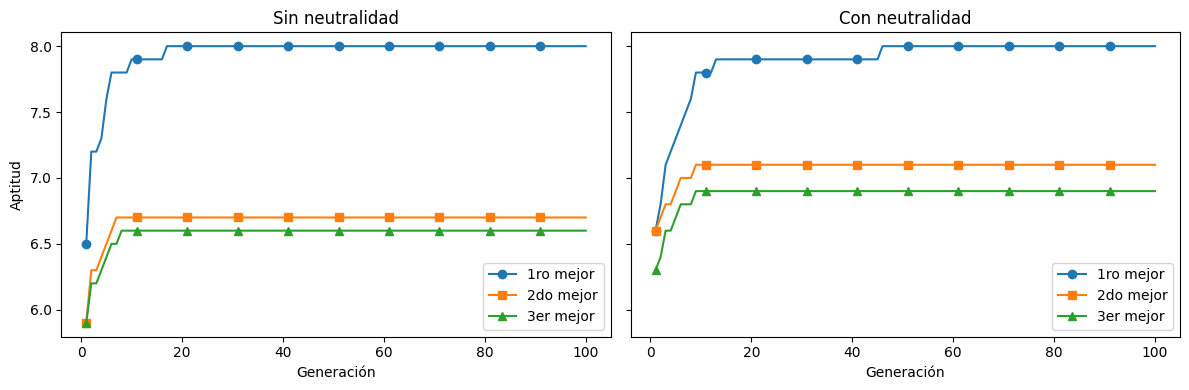

In [ ]:
import matplotlib.pyplot as plt
avg_sin = hist_sin.mean(axis=0)   
avg_con = hist_con.mean(axis=0)

gens    = np.arange(1, ngen+1)
labels  = ['1ro mejor','2do mejor','3er mejor']
markers = ['o','s','^']

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
# Sin neutralidad
for j in range(3):
    axes[0].plot(gens, avg_sin[:, j],
                 marker=markers[j], markevery=10,
                 label=labels[j])
axes[0].set_title('Sin neutralidad')
axes[0].set_xlabel('Generación')
axes[0].set_ylabel('Aptitud')
axes[0].legend()

# Con neutralidad
for j in range(3):
    axes[1].plot(gens, avg_con[:, j],
                 marker=markers[j], markevery=10,
                 label=labels[j])
axes[1].set_title('Con neutralidad')
axes[1].set_xlabel('Generación')
axes[1].legend()

plt.tight_layout()
plt.show()